<a href="https://colab.research.google.com/github/shiri9/Federated-Machine-Learning/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flwr[simulation] torch torchvision matplotlib;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 22.0 MB/s eta 0:00:00


In [2]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
#from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset, random_split

import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


#reading training csv file from google drive
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kdd_test.csv')

#creating copies of datasets
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_train_labels = df_train_copy['labels']
df1_train_labels_in_numbers = df1_train_labels.replace({ 'normal' : 0, 'neptune' : 1,'land' : 1, 'back': 1, 'teardrop': 1, 'pod': 1, 'smurf' : 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2,
                                                     'phf': 3, 'multihop': 3, 'warezclient': 3,'warezmaster': 3, 'spy': 3, 'ftp_write' : 3,
                                                     'guess_passwd': 3,'imap': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4 })
#replacing the string output clsses by numbers
df_train_copy['labels'] = df1_train_labels_in_numbers

#Encoding categories in 0-Normal, 1-DoS, 2-Probe, 3-R2L, 4-U2R
df1_test_labels = df_test_copy['labels']
df1_test_labels_in_numbers = df1_test_labels.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1,
                                                      'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1,
                                                     'ipsweep' : 2, 'nmap' : 2, 'portsweep' : 2, 'satan' : 2, 'mscan' : 2,'saint' : 2,
                                                     'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3, 'warezclient': 3,
                                                       'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,
                                                       'xsnoop': 3,'httptunnel': 3,
                                                     'buffer_overflow': 4, 'loadmodule': 4,'perl': 4,  'rootkit': 4, 'ps': 4,'xterm': 4 })
#replacing the string output clsses by numbers
df_test_copy['labels'] = df1_test_labels_in_numbers

#Transform categorical features into numbers using LabelEncoder() from train dataset
dft = df_train_copy.apply(LabelEncoder().fit_transform)
df_train_copy = dft

#Transform categorical features into numbers using LabelEncoder() from test dataset
dftt = df_test_copy.apply(LabelEncoder().fit_transform)
df_test_copy = dftt

# Dropping the column "num_outbound_cmds" from train and test datasets
df_train_copy = df_train_copy.drop('num_outbound_cmds', axis=1)
df_test_copy = df_test_copy.drop('num_outbound_cmds', axis=1)

from sklearn.preprocessing import MinMaxScaler

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_train_copy[numerical_columns])

# Transform the selected columns with the scaler
df_train_copy[numerical_columns] = scaler.transform(df_train_copy[numerical_columns])

# Select the columns to be normalized (assuming they are numerical features)
numerical_columns = ['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
                     'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                     'dst_host_same_src_port_rate','dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate',
                     'srv_rerror_rate','diff_srv_rate', 'srv_diff_host_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','hot','num_compromised','num_root',]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the selected columns
scaler.fit(df_test_copy[numerical_columns])

# Transform the selected columns with the scaler
df_test_copy[numerical_columns] = scaler.transform(df_test_copy[numerical_columns])

In [ ]:
df_train_copy.shape

(125973, 41)

In [ ]:
# Determine the number of partitions
num_partitions = 10

# Split your DataFrame into 10 partitions
partition_size = len(df_train_copy) // num_partitions
data_partitions = []

for i in range(num_partitions):
    start_index = i * partition_size
    end_index = (i + 1) * partition_size if i < num_partitions - 1 else len(df_train_copy)
    partition = df_train_copy.iloc[start_index:end_index]
    data_partitions.append(partition)

# Create DataLoaders for each partition with validation datasets
batch_size = 64  # Set your desired batch size
dataloaders = []
val_loaders = []

for partition in data_partitions:
    # Split each partition into training and validation subsets (90% train, 10% validation)
    len_partition = len(partition)
    len_train = int(0.9 * len_partition)
    len_val = len_partition - len_train

    train_partition, val_partition = random_split(partition, [len_train, len_val], generator=torch.Generator().manual_seed(42))

    # Prepare training DataLoader
    train_features = train_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    train_labels = train_partition.dataset['labels']  # Replace 'labels' with your label column name

    train_features_tensor = torch.Tensor(train_features.values)
    train_labels_tensor = torch.Tensor(train_labels.values)

    train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Prepare validation DataLoader
    val_features = val_partition.dataset.drop(columns=['labels'])  # Replace 'labels' with your label column name
    val_labels = val_partition.dataset['labels']  # Replace 'labels' with your label column name

    val_features_tensor = torch.Tensor(val_features.values)
    val_labels_tensor = torch.Tensor(val_labels.values)

    val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    dataloaders.append(train_dataloader)
    val_loaders.append(val_dataloader)

# Create a DataLoader for the test dataset
test_features = df_test_copy.drop(columns=['labels'])  # Replace 'labels' with your label column name
test_labels = df_test_copy['labels']  # Replace 'labels' with your label column name

test_features_tensor = torch.Tensor(test_features.values)
test_labels_tensor = torch.Tensor(test_labels.values)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Now 'dataloaders' is a list of training DataLoaders, 'val_loaders' is a list of validation DataLoaders,
# and 'test_dataloader' is the DataLoader for the test dataset.
# Each partition has its own training and validation DataLoader.
# You can use these for federated learning, and validation during training, and testing.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define your layers here
        self.fc1 = nn.Linear(40, 128)  # 40 input features, 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # 128 hidden units, 64 hidden units
        self.fc3 = nn.Linear(64, 5)   # 64 hidden units, 5 output classes (assuming you have 5 classes)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for data, labels in trainloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.to(DEVICE), labels.long().to(DEVICE)
            outputs = net(data)
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
net = Net().to(DEVICE)
num_clients = 10

for epoch in range(5):
    print(f"Training for epoch {epoch+1}")
    for i in range(num_clients):
        dataloader = dataloaders[i]
        valloader = val_loaders[i]
        train(net, dataloader, 1)
        loss, accuracy = test(net, valloader)
        print(f"Client {i+1} Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

    print(f"End of epoch {epoch+1}")

# After all epochs, test the model with the testloader
loss, accuracy = test(net, test_dataloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")


Training for epoch 1
Client 1 Epoch 1: validation loss 0.1407406695073631, accuracy 0.9630864491545607
Client 2 Epoch 1: validation loss 0.07595304871063094, accuracy 0.9790426291974279
Client 3 Epoch 1: validation loss 0.05189337171046867, accuracy 0.981821068508375
Client 4 Epoch 1: validation loss 0.045932097985707035, accuracy 0.9852345796618243
Client 5 Epoch 1: validation loss 0.036811415793913116, accuracy 0.9899976184805906
Client 6 Epoch 1: validation loss 0.035332780574840794, accuracy 0.9896800825593395
Client 7 Epoch 1: validation loss 0.0302360727000263, accuracy 0.9903945383821545
Client 8 Epoch 1: validation loss 0.03256071995480487, accuracy 0.988806858775899
Client 9 Epoch 1: validation loss 0.032732916596998, accuracy 0.9882511709137096
Client 10 Epoch 1: validation loss 0.031700834389929634, accuracy 0.9888095238095238
End of epoch 1
Training for epoch 2
Client 1 Epoch 2: validation loss 0.029831356859292012, accuracy 0.9909502262443439
Client 2 Epoch 2: validation l

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = dataloaders[int(cid)]
    valloader = val_loaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [ ]:
NUM_CLIENTS = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-19 10:29:52,496 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-09-19 10:29:55,913	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 10:29:58,565 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7796318208.0, 'object_store_memory': 3898159104.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7796318208.0, 'object_store_memory': 3898159104.0}
INFO flwr 2023-09-19 10:29:58,576 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 10:29:58,587 | app.py:224 | Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
	round 1: 0.09209086932100091
	round 2: 0.05183703901304102
	round 3: 0.040346809476008286
	round 4: 0.03578528500007534
	round 5: 0.03324927903699534
	round 6: 0.030033912924184083
	round 7: 0.028040040187215017
	round 8: 0.02747217892659132
	round 9: 0.026027355988735693
	round 10: 0.024444369013839107
	round 11: 0.023649127171303023
	round 12: 0.02370186652926793
	round 13: 0.022135578311456714
	round 14: 0.021212361280346058
	round 15: 0.020448947227528776
	round 16: 0.019637855242276576
	round 17: 0.019579270916841463
	round 18: 0.02033889214724206
	round 19: 0.02030662669412177
	round 20: 0.018417188163136512

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=20),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-19 10:38:37,560 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-09-19 10:38:43,880	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-19 10:38:47,145 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7785846375.0, 'object_store_memory': 3892923187.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7785846375.0, 'object_store_memory': 3892923187.0, 'CPU': 2.0}
INFO flwr 2023-09-19 10:38:47,153 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-19 10:38:47,165 | app.py:224 | Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
	round 1: 0.09416728205860682
	round 2: 0.05224153986841861
	round 3: 0.041970317696958664
	round 4: 0.037183707845997095
	round 5: 0.03527138943103692
	round 6: 0.031208670472158258
	round 7: 0.03055747299071586
	round 8: 0.02934540370629362
	round 9: 0.028112888549827946
	round 10: 0.025224274686823884
	round 11: 0.0239353497985742
	round 12: 0.024214078577410574
	round 13: 0.022856548931122694
	round 14: 0.02209614846678406
	round 15: 0.0209012055670654
	round 16: 0.019426717251284396
	round 17: 0.020048691636923553
	round 18: 0.018259978290325076
	round 19: 0.01703838863246268
	round 20: 0.01719649562605094
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9719774549495912), (2, 0.9828689370485035), (3, 0.9863618321822656), (4, 0.9894101770262761), (5, 0.9900293720727159), (6, 0.9906803207112805), (7, 0.9913312693498453), (8, 0.9920774787647854), (9, 0.9918393268238469), (10, 0.9926490434230373), (11, 0.9928081326997735), (12, 0.993109470508

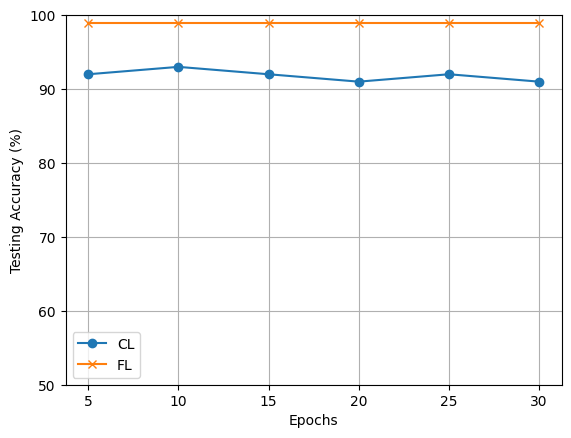

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
epochs = [5, 10, 15, 20, 25, 30]
cl_accuracy = [92, 93, 92, 91, 92, 91]
fl_accuracy = [99, 99, 99, 99, 99, 99]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot CL accuracy with lines and markers at epoch points
ax.plot(epochs, cl_accuracy, marker='o', linestyle='-', label='CL')

# Plot FL accuracy with lines and markers at epoch points
ax.plot(epochs, fl_accuracy, marker='x', linestyle='-', label='FL')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Testing Accuracy (%)')
ax.grid(True)

# Add a legend
ax.legend()

# Set y-axis limits between 50 and 100
ax.set_ylim(50, 100)

# Set x-axis ticks to only display specified epoch values
ax.set_xticks(epochs)

# Save the plot as a PNG image
plt.savefig('acc_vs_epochs.png')

#


In [ ]:
from google.colab import files

# Download the plot
files.download('acc_vs_epochs.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>